# This cat does not exist
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW06] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

Цель этого задания - создать котов, которых не существует. В ходе данного задания вы обучите DCGAN и VAE, которые являются одними из первых генеративных моделей. Для этого задания вам наверняка потребуется GPU с CUDA, поэтому рекомендуется использовать Google Colab.

In [64]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import os 
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import numpy as np

%matplotlib inline

In [65]:
def random_noise(batch_size, channels, side_size):
    return torch.randn(batch_size, channels, side_size, side_size).cuda()

def imagewide_average(x):
    return x.mean(dim=(-1, -2))

In [80]:
def visualise(imgs, rows=2):
    imgs = imgs.transpose(1, 3)
    imgs = torch.cat([imgs[i::rows] for i in range(rows)], dim=1)
    cols = len(imgs)
    imgs = (torch.cat(list(imgs), dim=1)).cpu().numpy()[:, :, ::-1]
    
    imgs = (imgs + 1) / 2
    
    plt.figure(figsize=(cols*1.5, rows*1.5))
    plt.imshow(imgs)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [81]:
class CatDataset(Dataset):
    def __init__(self, path_to_dataset="cat_136", size=128):
        self.photo_names = os.listdir(path_to_dataset)
        self.path_base = path_to_dataset
        self.size = size
    
    def __getitem__(self, index):
        path = self.path_base + "/" + self.photo_names[index]
        img = cv2.imread(path) # 136 x 136
        crop_rate = 8
        x_crop = random.randint(0, crop_rate)
        y_crop = random.randint(0, crop_rate)
        img = img[x_crop:136 - crop_rate + x_crop, y_crop:136 - crop_rate + y_crop]
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_CUBIC)
        return 2 * torch.tensor(img).float().transpose(0, 2) / 255. - 1
    
    def __len__(self):
        return len(self.photo_names)

In [68]:
dataset = CatDataset()
visualise(torch.cat([dataset[i].unsqueeze(0) for i in [3, 15, 20]], dim=0))

### Задание 1 (2 балла)
Для начала реализуем генератор для нашего DCGAN. Предлагается использовать следующую архитектуру:

![](imgs/DCGAN.png)

Для ее реализации вам потребуются модули `nn.BatchNorm2d`, `nn.Conv2d`, `nn.ConvTranspose2D`, `nn.ReLU`, а также функция `F.interpolate`.

#### Методы
* `__init__` - принимает на вход `start_size`, `latent_channels`, `start_channels` и `upsamplings`. Первые два аргумента отвечают за размер случайного шума, из которого в последствии будет сгенерирована картинка. `start_channels` отвечает за то, сколько каналов должно быть в картинке перед тем, как к ней будут применены upsampling блоки. `upsamplings` - это количество upsampling блоков, которые должны быть применены к картинке. В каждом таком блоке количество каналов уменьшается в два раза.


* `forward` - принимает на вход `batch_size`, генерирует `batch_size` картинок из случайного шума.

In [71]:
class Generator(nn.Module):
    def __init__(self, start_size=2, latent_channels=32, start_channels=1024, upsamplings=6):
        super().__init__()
        self.start_size = start_size
        self.upsamplings = upsamplings
        self.latent_channels = latent_channels
        self.module = nn.Sequential()
        layer1 = nn.Conv2d(in_channels=latent_channels,
                                out_channels=start_channels,
                                kernel_size=1,
                                stride = 1,
                                padding=0,
                                bias=False)
        transpose_layer = nn.ConvTranspose2d(in_channels=start_channels,
                                                  out_channels=start_channels // 2,
                                                  kernel_size=4,
                                                  stride = 2,
                                                  padding=1,
                                                  bias=False)
        output_channels = start_channels // 2
        self.module.add_module("layer_1", layer1)
        self.module.add_module("transpose_1", transpose_layer)
        self.module.add_module("batch_1", nn.BatchNorm2d(output_channels))
        self.module.add_module("relu_1", nn.ReLU())
        
        for _ in range(upsamplings - 1):
            self.module.add_module("transpose_" + str(_ + 2), nn.ConvTranspose2d(in_channels=output_channels,
                                                               out_channels=output_channels // 2,
                                                               kernel_size=4,
                                                               stride=2,
                                                               padding=1,
                                                               bias=False
                                                               ))
            output_channels = output_channels // 2
            self.module.add_module("batch_" + str(_ + 2), nn.BatchNorm2d(output_channels))
            self.module.add_module("relu_" + str(_ + 2), nn.ReLU())
        

        self.module.add_module("conv2d", nn.Conv2d(in_channels=output_channels,
                                                   out_channels=3,
                                                   kernel_size=1,
                                                   stride=1,
                                                   padding=0,
                                                   bias=False
                                                   ))
        self.module.cuda()


    def forward(self, batch_size: int):
        latent_data = random_noise(batch_size, self.latent_channels, self.start_size)
        return self.module(latent_data)
  

### Задание 2 (2 балла)
Для начала реализуем дискриминатор для нашего DCGAN. Предлагается использовать следующую архитектуру:

![](imgs/Disc_DCGAN.png)

Для ее реализации вам потребуются модули `nn.BatchNorm2d`, `nn.Conv2d`, `nn.ReLU` и `nn.Sigmoid`.

#### Методы
* `__init__` - принимает на вход `start_channels` и `downsamplings`. `start_channels` определяет количество каналов, которые должны быть в изображении перед применением downsampling блоков.


* `forward` - принимает на вход `x` - тензор с картинками. Возвращает вектор с размерностью `batch_size`.

In [74]:
class Discriminator(nn.Module):
    def __init__(self, downsamplings=6, start_channels=8):
        super().__init__()
        self.start_channels = start_channels
        self.downsamplings = downsamplings
        self.module = nn.Sequential()
        layer1 = nn.Conv2d(in_channels=3,
                                out_channels=start_channels,
                                kernel_size=1,
                                stride = 1,
                                padding=0,
                                bias=False)
        transpose_layer = nn.Conv2d(in_channels=start_channels,
                                                  out_channels=start_channels * 2,
                                                  kernel_size=3,
                                                  stride = 2,
                                                  padding=1,
                                                  bias=False)
        output_channels = start_channels * 2
        self.module.add_module("layer_1", layer1)
        self.module.add_module("transpose_1", transpose_layer)
        self.module.add_module("batch_1", nn.BatchNorm2d(output_channels))
        self.module.add_module("relu_1", nn.ReLU())
        
        for _ in range(downsamplings - 1):
            self.module.add_module("transpose_" + str(_ + 2), nn.Conv2d(in_channels=output_channels,
                                                               out_channels=output_channels * 2,
                                                               kernel_size=3,
                                                               stride=2,
                                                               padding=1,
                                                               bias=False
                                                               ))
            output_channels = output_channels * 2
            self.module.add_module("batch_" + str(_ + 2), nn.BatchNorm2d(output_channels))
            self.module.add_module("relu_" + str(_ + 2), nn.ReLU())
        
        self.module.add_module("flatten", nn.Flatten(1, -1))
        C = self.start_channels * (128 ** 2) // (2 ** self.downsamplings)
        self.module.add_module("linear", nn.Linear(C, 1, bias=False))
        self.module.add_module("sigmoid", nn.Sigmoid())
        self.module.cuda()
        
    def forward(self, x):
        return self.module(x) 


In [85]:
def train_gan():
    generator = Generator()
    discriminator = Discriminator()
    epochs = 120
    visualise_every = 10
    batch_size = 8
    generator.cuda()
    discriminator.cuda()

    gen_optim = Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    disc_optim = Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

    dataset = CatDataset(size=128)

    for ep in range(epochs):
        dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
        total_batches = 0
        gen_loss_avg = 0
        disc_loss_avg = 0

        for i, batch in tqdm(enumerate(dataloader), total=(len(dataset) + batch_size) // batch_size):
            if len(batch) < batch_size:
                continue
            total_batches += 1
            # Positive update
            batch = batch.cuda()
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.ones_like(pred))
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_loss_avg += loss.item()

            # Negative update
            batch = generator(batch_size).detach()
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.zeros_like(pred))
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_loss_avg += loss.item()

            # Generator update
            batch = generator(batch_size)
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.ones_like(pred))
            gen_optim.zero_grad()
            loss.backward()
            gen_optim.step()
            gen_loss_avg += loss.item()
        
        if (ep + 1) % visualise_every == 0:
            with torch.no_grad():
                visualise(generator(6), rows=2)

        print(f"Epoch {ep+1} | Discriminator loss: {disc_loss_avg / total_batches} | Generator loss: {gen_loss_avg / total_batches}")


Epoch 1 | Discriminator loss: 0.3392802904613852 | Generator loss: 4.204180273323952



Epoch 2 | Discriminator loss: 0.19038434212383326 | Generator loss: 5.301985255053211



Epoch 3 | Discriminator loss: 0.5790435647098254 | Generator loss: 3.4624157713408454



Epoch 4 | Discriminator loss: 0.6381482580944546 | Generator loss: 2.871229033805056



Epoch 5 | Discriminator loss: 0.713364000958593 | Generator loss: 2.712166033859636



Epoch 6 | Discriminator loss: 0.7850537198131599 | Generator loss: 2.4654245039691096



Epoch 7 | Discriminator loss: 0.8040646281510742 | Generator loss: 2.4195164641409015



Epoch 8 | Discriminator loss: 0.8735337222997959 | Generator loss: 2.156428133065884



Epoch 9 | Discriminator loss: 0.8364499610876758 | Generator loss: 2.19081454073705


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


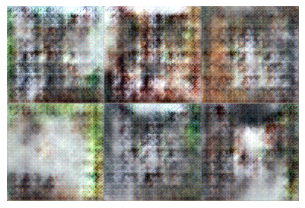

Epoch 10 | Discriminator loss: 0.8591375792504952 | Generator loss: 2.154646604156813



Epoch 11 | Discriminator loss: 0.8254009855468836 | Generator loss: 2.1307385398392693



Epoch 12 | Discriminator loss: 0.8040115576935153 | Generator loss: 2.2212151647810154



Epoch 13 | Discriminator loss: 0.837574707051384 | Generator loss: 2.125327351699306



Epoch 14 | Discriminator loss: 0.8096068368097113 | Generator loss: 2.0951898657159265



Epoch 15 | Discriminator loss: 0.8058863947834558 | Generator loss: 2.1049812252704916



Epoch 16 | Discriminator loss: 0.8083387392146332 | Generator loss: 2.1551650304060717



Epoch 17 | Discriminator loss: 0.7687975796543834 | Generator loss: 2.080175241897736



Epoch 18 | Discriminator loss: 0.7172045280353282 | Generator loss: 2.280215218314359



Epoch 19 | Discriminator loss: 0.7191011007302083 | Generator loss: 2.2031898138714476


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


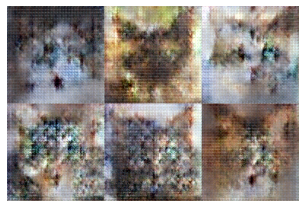

Epoch 20 | Discriminator loss: 0.6898172271895817 | Generator loss: 2.295267398740137



Epoch 21 | Discriminator loss: 0.6762468670261245 | Generator loss: 2.408991154021643



Epoch 22 | Discriminator loss: 0.6320479117539465 | Generator loss: 2.457162454973495



Epoch 23 | Discriminator loss: 0.5643296115190712 | Generator loss: 2.632985894097931



Epoch 24 | Discriminator loss: 0.5861136744477876 | Generator loss: 2.6145959026040044



Epoch 25 | Discriminator loss: 0.5311574047013967 | Generator loss: 2.695986878513094



Epoch 26 | Discriminator loss: 0.5268505644574948 | Generator loss: 2.8238826043231033



Epoch 27 | Discriminator loss: 0.4888187545603982 | Generator loss: 2.8862463839875416



Epoch 28 | Discriminator loss: 0.48945176955016584 | Generator loss: 3.124240317671594



Epoch 29 | Discriminator loss: 0.495084258885805 | Generator loss: 3.0503789343961505


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


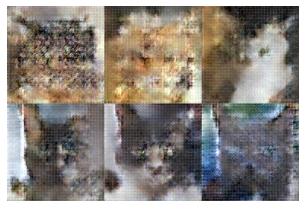

Epoch 30 | Discriminator loss: 0.4908641571425101 | Generator loss: 2.8969712697941326



Epoch 31 | Discriminator loss: 0.45754139243864944 | Generator loss: 3.0782849296279577



Epoch 32 | Discriminator loss: 0.45804680631158057 | Generator loss: 3.1241444462916523



Epoch 33 | Discriminator loss: 0.420763606897845 | Generator loss: 3.215817129731577



Epoch 34 | Discriminator loss: 0.4252073315371694 | Generator loss: 3.313262852936684



Epoch 35 | Discriminator loss: 0.43006731375442964 | Generator loss: 3.052256413726105



Epoch 36 | Discriminator loss: 0.4434407936970946 | Generator loss: 3.3074167755535213



Epoch 37 | Discriminator loss: 0.3841348541363214 | Generator loss: 3.4320838407529237



Epoch 38 | Discriminator loss: 0.38072344909475053 | Generator loss: 3.5279099383083077



Epoch 39 | Discriminator loss: 0.37282870595933665 | Generator loss: 3.5080233126579716


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


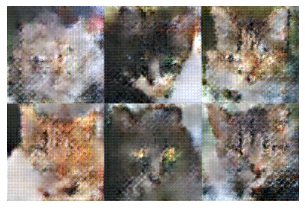

Epoch 40 | Discriminator loss: 0.38478736972115485 | Generator loss: 3.3748842559530585



Epoch 41 | Discriminator loss: 0.37360321910994243 | Generator loss: 3.4513190273058454



Epoch 42 | Discriminator loss: 0.3446397452247656 | Generator loss: 3.5556918639801816



Epoch 43 | Discriminator loss: 0.3672313668405369 | Generator loss: 3.6661814873832523



Epoch 44 | Discriminator loss: 0.341069050967603 | Generator loss: 3.654143675314543



Epoch 45 | Discriminator loss: 0.3828193482294224 | Generator loss: 3.7038520765942473



Epoch 46 | Discriminator loss: 0.3516832812067065 | Generator loss: 3.639900993543325



Epoch 47 | Discriminator loss: 0.3427677112508855 | Generator loss: 3.6909198478910836



Epoch 48 | Discriminator loss: 0.32145264298253284 | Generator loss: 3.8677913454862742



Epoch 49 | Discriminator loss: 0.31391979732079955 | Generator loss: 3.7842591125829563


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


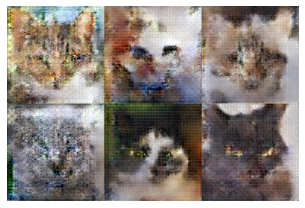

Epoch 50 | Discriminator loss: 0.32607733013994533 | Generator loss: 3.8078542385611645



Epoch 51 | Discriminator loss: 0.362281066189165 | Generator loss: 3.7619536481174736



Epoch 52 | Discriminator loss: 0.3132089325866349 | Generator loss: 3.852170944213867



Epoch 53 | Discriminator loss: 0.30735640554458377 | Generator loss: 3.8246025807881434



Epoch 54 | Discriminator loss: 0.3265156394509633 | Generator loss: 3.805430234674626



Epoch 55 | Discriminator loss: 0.2712448641243562 | Generator loss: 3.9448259560559507



Epoch 56 | Discriminator loss: 0.31122909896122447 | Generator loss: 4.0432392271067386



Epoch 57 | Discriminator loss: 0.28107390864666576 | Generator loss: 4.009114869462207



Epoch 58 | Discriminator loss: 0.2644549565840229 | Generator loss: 3.881765118211408



Epoch 59 | Discriminator loss: 0.29916797507891857 | Generator loss: 3.9548000998321586


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


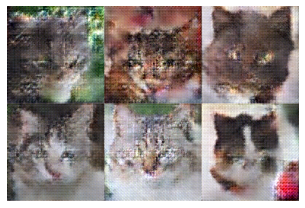

Epoch 60 | Discriminator loss: 0.2650863882055429 | Generator loss: 4.107540234275486



Epoch 61 | Discriminator loss: 0.26705750957273305 | Generator loss: 4.193135774255198



Epoch 62 | Discriminator loss: 0.26367534519950736 | Generator loss: 4.139585077563257



Epoch 63 | Discriminator loss: 0.27308682868332895 | Generator loss: 4.242790249677805



Epoch 64 | Discriminator loss: 0.2550876651971171 | Generator loss: 4.1252649412506



Epoch 65 | Discriminator loss: 0.2771442753556679 | Generator loss: 4.158282766374058



Epoch 66 | Discriminator loss: 0.2666535181579154 | Generator loss: 4.256646729432619



Epoch 67 | Discriminator loss: 0.2405399576425307 | Generator loss: 4.438905346752409



Epoch 68 | Discriminator loss: 0.26504203031838924 | Generator loss: 4.457480405286004



Epoch 69 | Discriminator loss: 0.22593290049843195 | Generator loss: 4.335017480180415


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


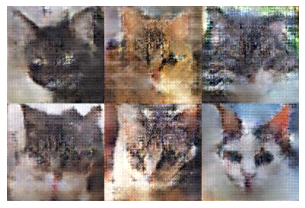

Epoch 70 | Discriminator loss: 0.22177357457954 | Generator loss: 4.211063051104147



Epoch 71 | Discriminator loss: 0.2495088932384448 | Generator loss: 4.580004711613607



Epoch 72 | Discriminator loss: 0.19826067788563403 | Generator loss: 4.422783042276185



Epoch 73 | Discriminator loss: 0.22085934163972168 | Generator loss: 4.565727307246282



Epoch 74 | Discriminator loss: 0.2454144374487776 | Generator loss: 4.799818298689099



Epoch 75 | Discriminator loss: 0.2325669292530495 | Generator loss: 4.524188963864559



Epoch 76 | Discriminator loss: 0.2276551634961265 | Generator loss: 4.593424271381021



Epoch 77 | Discriminator loss: 0.2203717845781935 | Generator loss: 4.772581490186544



Epoch 78 | Discriminator loss: 0.2455574954739409 | Generator loss: 4.681146089049885



Epoch 79 | Discriminator loss: 0.1937249119498749 | Generator loss: 4.806150930980376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


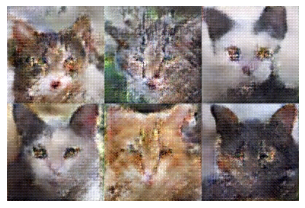

Epoch 80 | Discriminator loss: 0.22310871367084242 | Generator loss: 4.68189340371352



Epoch 81 | Discriminator loss: 0.23198901497117766 | Generator loss: 4.628134413905766



Epoch 82 | Discriminator loss: 0.20702572257421428 | Generator loss: 4.76304469140477



Epoch 83 | Discriminator loss: 0.21241657468200237 | Generator loss: 4.652696001290478



Epoch 84 | Discriminator loss: 0.20568478267765586 | Generator loss: 4.765163959866782



Epoch 85 | Discriminator loss: 0.18045426596644845 | Generator loss: 5.027781098981366



Epoch 86 | Discriminator loss: 0.19413559570836567 | Generator loss: 5.0662885639181106



Epoch 87 | Discriminator loss: 0.1885925191983252 | Generator loss: 4.807237587246209



Epoch 88 | Discriminator loss: 0.18466309686218998 | Generator loss: 5.229701818630448



Epoch 89 | Discriminator loss: 0.20118155354896203 | Generator loss: 4.838676409777191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


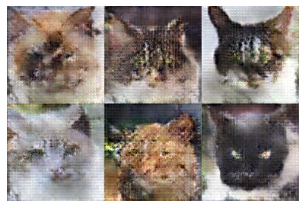

Epoch 90 | Discriminator loss: 0.16632796640099887 | Generator loss: 4.9475639966818



Epoch 91 | Discriminator loss: 0.21035926348198955 | Generator loss: 5.191189769119722



Epoch 92 | Discriminator loss: 0.2109258209255551 | Generator loss: 4.968421689642712



Epoch 93 | Discriminator loss: 0.19095769260747814 | Generator loss: 4.764882107642183



Epoch 94 | Discriminator loss: 0.17991054916200083 | Generator loss: 5.10018011817964



Epoch 95 | Discriminator loss: 0.1925530350710815 | Generator loss: 5.149563927315549



Epoch 96 | Discriminator loss: 0.1913079716057922 | Generator loss: 4.979671775098629



Epoch 97 | Discriminator loss: 0.20374590785976152 | Generator loss: 4.808416663204945



Epoch 98 | Discriminator loss: 0.21074521625286005 | Generator loss: 4.834160085505865



Epoch 99 | Discriminator loss: 0.17856333257848891 | Generator loss: 4.955604327163568


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


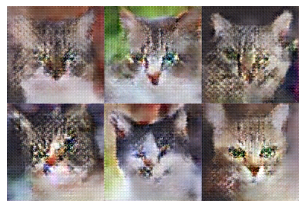

Epoch 100 | Discriminator loss: 0.14752661609285053 | Generator loss: 5.227134072262308



Epoch 101 | Discriminator loss: 0.15711727459591257 | Generator loss: 5.386606286201987



Epoch 102 | Discriminator loss: 0.1728752471484354 | Generator loss: 5.319670928361822



Epoch 103 | Discriminator loss: 0.18202860369631382 | Generator loss: 4.896723819217554



Epoch 104 | Discriminator loss: 0.14598666386147646 | Generator loss: 5.408911771598867



Epoch 105 | Discriminator loss: 0.15824527738825364 | Generator loss: 5.434522732544105



Epoch 106 | Discriminator loss: 0.16563510449308233 | Generator loss: 5.313043377271863



Epoch 107 | Discriminator loss: 0.16260048005831193 | Generator loss: 5.089098001403554



Epoch 108 | Discriminator loss: 0.13840862579433594 | Generator loss: 5.374785519363888



Epoch 109 | Discriminator loss: 0.16031900810111038 | Generator loss: 5.321263324855562


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


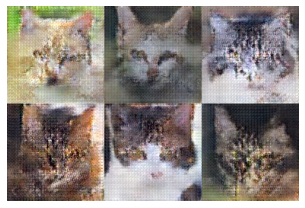

Epoch 110 | Discriminator loss: 0.16978402044006363 | Generator loss: 5.342484093828744



Epoch 111 | Discriminator loss: 0.1423009284949954 | Generator loss: 5.59690486148847



Epoch 112 | Discriminator loss: 0.1425615908659175 | Generator loss: 5.4473734583743045



Epoch 113 | Discriminator loss: 0.15003559213825998 | Generator loss: 5.282711666961976



Epoch 114 | Discriminator loss: 0.1526068628405197 | Generator loss: 5.4662057851070545



Epoch 115 | Discriminator loss: 0.17123780350110576 | Generator loss: 5.570939703529894



Epoch 116 | Discriminator loss: 0.14419176920308743 | Generator loss: 5.589410332134336



Epoch 117 | Discriminator loss: 0.1650852192338351 | Generator loss: 5.577770743082997



Epoch 118 | Discriminator loss: 0.13165543607090477 | Generator loss: 5.43886227312694



Epoch 119 | Discriminator loss: 0.15868597084961364 | Generator loss: 5.558424117373782


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


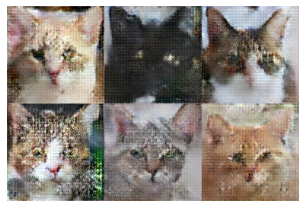

Epoch 120 | Discriminator loss: 0.16289065640683742 | Generator loss: 5.3741466177745805


In [82]:
generator = Generator()
discriminator = Discriminator()
epochs = 120
visualise_every = 10
batch_size = 8
generator.cuda()
discriminator.cuda()

gen_optim = Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
disc_optim = Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

dataset = CatDataset(size=128)

for ep in range(epochs):
    dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
    total_batches = 0
    gen_loss_avg = 0
    disc_loss_avg = 0

    for i, batch in tqdm(enumerate(dataloader), total=(len(dataset) + batch_size) // batch_size):
        if len(batch) < batch_size:
            continue
        total_batches += 1
        # Positive update
        batch = batch.cuda()
        pred = discriminator(batch)
        loss = F.binary_cross_entropy(pred, torch.ones_like(pred))
        disc_optim.zero_grad()
        loss.backward()
        disc_optim.step()
        disc_loss_avg += loss.item()

        # Negative update
        batch = generator(batch_size).detach()
        pred = discriminator(batch)
        loss = F.binary_cross_entropy(pred, torch.zeros_like(pred))
        disc_optim.zero_grad()
        loss.backward()
        disc_optim.step()
        disc_loss_avg += loss.item()

        # Generator update
        batch = generator(batch_size)
        pred = discriminator(batch)
        loss = F.binary_cross_entropy(pred, torch.ones_like(pred))
        gen_optim.zero_grad()
        loss.backward()
        gen_optim.step()
        gen_loss_avg += loss.item()
    
    if (ep + 1) % visualise_every == 0:
        with torch.no_grad():
            visualise(generator(6), rows=2)

    print(f"Epoch {ep+1} | Discriminator loss: {disc_loss_avg / total_batches} | Generator loss: {gen_loss_avg / total_batches}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


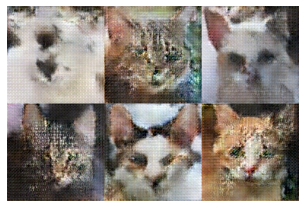

In [84]:
with torch.no_grad():
    visualise(generator(6), rows=2)